In [1]:
import sys
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
xgb.__version__

'0.6'

In [4]:
df=pd.read_csv('../input/newtrain_part1.csv',index_col=0)

In [5]:
trainx=df.drop(['target'],axis=1)
trainy=df['target']

In [6]:
trainx.shape

(297606, 62)

In [7]:
trainx.shape

(297606, 62)

In [8]:
297606*0.8

238084.80000000002

In [9]:
split = 238084
x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

d_all=xgb.DMatrix(trainx, label=trainy)


Building DMatrix...


In [10]:
print('Training ...')

params = {}
#params['eta'] = 0.02
params['objective'] = 'binary:logistic'
#params['objective'] = 'reg:abs'
params['eval_metric'] = 'auc'
params['max_depth'] = 6
params['nthread']=8
params['silent'] = 1
#params['gamma'] = 2
#params['min_child_weight']=50
params['tree_method']='hist'

params.update({'reg_alpha': 6, 'colsample_bytree': 0.8, 'scale_pos_weight': 1.3, 'learning_rate': 0.03, 'min_child_weight': 4, 'subsample': 0.8, 'reg_lambda': 1.3, 'objective': 'binary:logistic', 'max_depth': 6, 'gamma': 7})
print params
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=20)

Training ...
{'reg_alpha': 6, 'colsample_bytree': 0.8, 'silent': 1, 'eval_metric': 'auc', 'scale_pos_weight': 1.3, 'learning_rate': 0.03, 'nthread': 8, 'min_child_weight': 4, 'subsample': 0.8, 'reg_lambda': 1.3, 'objective': 'binary:logistic', 'tree_method': 'hist', 'max_depth': 6, 'gamma': 7}
[0]	train-auc:0.558393	valid-auc:0.562612
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[20]	train-auc:0.610039	valid-auc:0.609411
[40]	train-auc:0.617123	valid-auc:0.614897
[60]	train-auc:0.626186	valid-auc:0.622896
[80]	train-auc:0.633155	valid-auc:0.626425
[100]	train-auc:0.641207	valid-auc:0.630495
[120]	train-auc:0.64786	valid-auc:0.63295
[140]	train-auc:0.654028	valid-auc:0.635193
[160]	train-auc:0.660712	valid-auc:0.636356
[180]	train-auc:0.66663	valid-auc:0.637902
[200]	train-auc:0.672132	valid-auc:0.638262
[220]	train-auc:0.677064	valid-auc:0.638196
[240]	train-auc:0.681358	valid-auc:0.638639

In [11]:
clf.best_ntree_limit

256

In [12]:
print clf.get_dump(dump_format='text')[7]

0:[ps_car_13_float<0.968992] yes=1,no=2,missing=1
	1:[ps_ind_17_bin<1] yes=3,no=4,missing=3
		3:leaf=-0.0462179
		4:[ps_car_07_cat<0] yes=7,no=8,missing=7
			7:[ps_reg_03_M<131] yes=11,no=12,missing=11
				11:leaf=-0.025948
				12:leaf=-0
			8:leaf=-0.0437101
	2:leaf=-0.043012



In [13]:
import json
trees=[json.loads(u) for u in clf.get_dump(dump_format='json')[:clf.best_ntree_limit]]
len(trees)

256

In [14]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [15]:
tree= (trees[7])

In [16]:
g=nx.DiGraph()

In [17]:
def addNode(node):
    g.add_node(node['nodeid'])
    if 'children' in node:
        for u in node['children']:
            addNode(u)
addNode(tree)            

In [18]:
def addEdge(node):
    n1=node['nodeid']
    if 'children' in node:
        for u in node['children']:
            g.add_edge(n1,u['nodeid'])
            addEdge(u)
addEdge(tree)            

/home/spark/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/spark/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/spark/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/spark/anaconda2/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/spark/anaconda2/lib/python2.7/

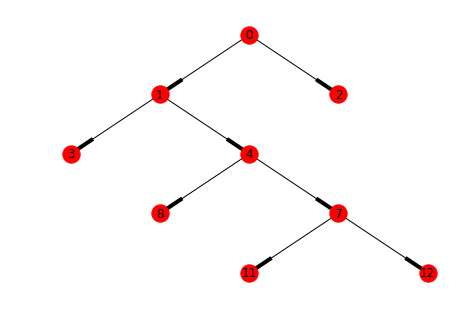

In [19]:
pos=graphviz_layout(g, prog='dot')
nx.draw(g,pos,with_labels=True)

In [20]:
def parse_tree(node):
    if 'leaf' in node:
        return [[]]
    nodeid=node['nodeid']
    split=node['split']
    split_cond=node['split_condition']
    yes=node['yes']
    no=node['no']
    missing=node['missing']
    children1=parse_tree([u for u in node["children"] if u['nodeid']==yes][0])
    children2=parse_tree([u for u in node["children"] if u['nodeid']==no][0])
    cond1=[('yes',split,split_cond)]
    cond2=[('no',split,split_cond)]
    if missing==yes:
        cond1.append(('missing',split))
    elif missing==no:
        cond2.append(('missing',split))
    else:
        raise 2
    cond1=sorted(cond1)
    cond2=sorted(cond2)
    ret1=[ sorted([cond1]+u) for u in children1]
    ret2=[ sorted([cond2]+u) for u in children2]
    return ret1+ret2
    
    

In [21]:
def enumerate_all_conds(tree):
    ret=[]
    cond_list=(parse_tree(tree))
    for cond in cond_list:
        for i in range(len(cond)):
            ret.append(cond[:i+1])
    return ret

In [22]:
cond_list=(enumerate_all_conds(trees[8]))
len(cond_list)

16

In [23]:
cond_list[12]

[[('missing', u'ps_car_01_cat'), ('yes', u'ps_car_01_cat', 0)],
 [('no', u'ps_car_03_cat', 0)],
 [('no', u'ps_ind_17_bin', 1)]]

In [24]:
all_conds=reduce(lambda u,v: u+v, [enumerate_all_conds(t) for t in trees])
len(all_conds)

24890

In [26]:
unique_conds={}
for u in all_conds:
    s=str(u)
    if s not in unique_conds:
        unique_conds[s]=u
unique_conds = list(unique_conds.values())

In [27]:
len(unique_conds)

18177

In [28]:
df.shape[0]*len(unique_conds)*64.0/1024**3

322.43634831905365

In [29]:
df.shape[0]*len(unique_conds)*16.0/1024**3

80.60908707976341

In [30]:
df.shape[0]*100000.*64/1024**3

1773.8699913024902

In [31]:
import cPickle as pickle
pickle.dump(unique_conds,open("bb_xgb_conds.pkl",'wb'))

In [38]:
def value_cond_tuple (df,cond):
    #print cond
    col=cond[1]
    if cond[0]=='missing':
        return np.isnan(df[col])
    else:
        split_val=cond[2]
        if cond[0]=='yes':
            return df[col]<split_val
        elif cond[0]=='no':
            return df[col]>=split_val
        else:
            raise "never be here"
def value_cond_single(df,conds):
    return reduce(lambda u,v: u | v, [value_cond_tuple(df,cond) for cond in conds])
def value_cond(df,conds):
    return reduce(lambda u,v: u & v, [value_cond_single(df,cond) for cond in conds])
def value_trees(df,trees):
    cond_lists=reduce(lambda u,v: u+v, [enumerate_all_conds(tree) for tree in trees])
    return cond_lists, pd.DataFrame([value_cond(df, conds) for conds in cond_lists]).T

In [40]:
value_cond(df,unique_conds[37]).mean()

0.0012466146515863255